In [1]:
import pandas as pd
import numpy as np
import time

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore')

import facts
from facts.models import customLogisticRegression
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative, print_recourse_report_KStest_cumulative
from facts.utils import load_rules_by_if, save_rules_by_if

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dataset

In [2]:
def preprocess_adult(df):
    df = df.drop(columns=["fnlwgt", "education"])
    cols = list(df.columns)
    df[cols] = df[cols].replace([" ?"], np.nan)
    df = df.dropna()
    df["relationship"] = df["relationship"].replace([" Husband", " Wife"], " Married")
    df["income"] = np.where((df["income"] == " <=50K"), 0, 1)
    
    return df

In [59]:
nbins = 10
sup_thres = 0.01

In [60]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

df = pd.read_csv(urlfile)
df = preprocess_adult(df)

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,40,Cuba,0


In [61]:
# df["hours-per-week"] = pd.cut(
#     df["hours-per-week"],
#     bins=[0.9, 25, 39, 40, 55, 100],
#     labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"],
# )
df["hours-per-week"] = pd.cut(df["hours-per-week"], bins=nbins)
df["age"] = pd.qcut(df["age"], q=nbins)
df["capital-loss"] = pd.cut(df["capital-loss"], bins=nbins)
df["capital-gain"] = pd.cut(df["capital-gain"], bins=nbins)

In [62]:
df["capital-loss"].value_counts()

capital-loss
(-4.356, 435.6]     43094
(1742.4, 2178.0]     1125
(1306.8, 1742.4]      639
(2178.0, 2613.6]      284
(871.2, 1306.8]        28
(435.6, 871.2]         23
(2613.6, 3049.2]       18
(3484.8, 3920.4]        8
(3049.2, 3484.8]        2
(3920.4, 4356.0]        1
Name: count, dtype: int64

In [63]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [66]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 3.38 s
Wall time: 3.72 s


array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [67]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10205
           1       0.73      0.61      0.67      3362

    accuracy                           0.85     13567
   macro avg       0.81      0.77      0.78     13567
weighted avg       0.84      0.85      0.84     13567



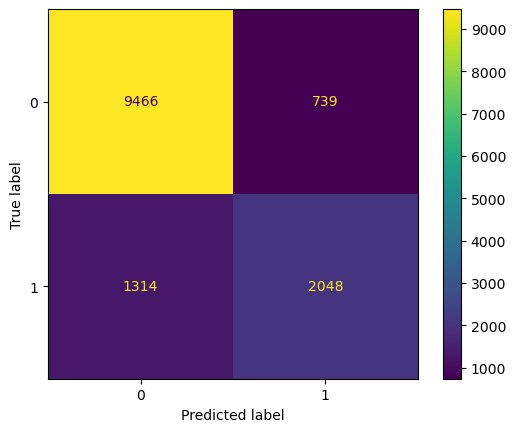

In [68]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Rules

In [69]:
start_time = time.time()
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='sex',
    freqitem_minsupp = sup_thres,
    missing_subgroup_val="Unknown",
    drop_infeasible = True,
    drop_above = True
)
end_time = time.time()

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]

Number of frequent itemsets for affected: {' Female': 25803, ' Male': 25834}
Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|████████████████████████████████████████████████████████████████████████| 25803/25803 [00:00<00:00, 462656.89it/s]

Number of groups from the intersection: 12601


Number of frequent itemsets for the unaffected: 59790
Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████████████████████████████████████████████████████████████████████| 12601/12601 [00:02<00:00, 4619.02it/s]


Computing correctenesses for all valid if-thens.


100%|████████████████████████████████████████████████████████████████████████████| 93062/93062 [50:27<00:00, 30.74it/s]


Number of if-thens: 93062


In [73]:
len(rules_by_if)

11454

In [70]:
try:
    runtimes
except NameError:
    runtimes = dict()

In [71]:
runtimes[(nbins, sup_thres)] = end_time - start_time

In [72]:
runtimes

{(10, 0.05): 114.3422486782074,
 (5, 0.05): 176.8317370414734,
 (20, 0.05): 97.29508805274963,
 (10, 0.1): 15.096330404281616,
 (10, 0.01): 3034.4781379699707}